<a href="https://colab.research.google.com/github/NicKylis/letter_recognition/blob/nick/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Digit Recognition using the MNIST dataset</center></h1>

In [40]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#import kagglehub
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Flatten, Dense
import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau

We first create a function to load the data in the image generators.

In [41]:
# def clean_image(img): Unused, increased losses in data
#     kernel = np.ones((3, 3), np.uint8)
#     img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
#     img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
#     return img
def get_MNIST_dataset(train_generator, batch_size=32, val_split=0.2, random_state=42):
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0 #Normalize data
    x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0
    #Split data to train and valitation
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_split, random_state=random_state)

    num_classes = 10  # MNIST has 10 classes (digits 0-9)
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)

    #Use default ImageDataGenerator for inmutable images
    val_test_generator = ImageDataGenerator()
    train_gen = train_generator.flow(x_train, y_train, batch_size=batch_size)
    val_gen = val_test_generator.flow(x_val, y_val, batch_size=batch_size)
    test_gen = val_test_generator.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

    return train_gen, val_gen, test_gen

We then create the image generators. For the train data we will use data augmentation in order to increase the accuracy of the model.

In [42]:
train_generator = ImageDataGenerator()
train_generator_aug = ImageDataGenerator(#Use this one, higher accuracy percentage
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,)

train_data, val_data, test_data = get_MNIST_dataset(train_generator, batch_size=32, val_split=0.2, random_state=42)
train_data_aug, val_data_aug, test_data_aug = get_MNIST_dataset(train_generator, batch_size=32, val_split=0.2, random_state=42)

We now create the model's architecture and layers.

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Dropout, UpSampling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model = keras.Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation=None, input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)) #Original image feature extraction

#Feature extraction from simulating Opening operation on image
model.add(MaxPooling2D((2, 2)))#Erosion
model.add(UpSampling2D(size=(2, 2)))#Dilation
model.add(Conv2D(64, (3, 3), activation=None))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.25))#0.15

#Feature extraction from simulating Closing operation on image
model.add(UpSampling2D(size=(2, 2)))#Dilation
model.add(MaxPooling2D(2, 2))#Erosion
model.add(Conv2D(64, (3, 3), activation=None))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=None))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=None))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Flatten())
model.add(Dense(90, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

from tensorflow.keras.losses import CategoricalCrossentropy
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.summary()

#Can use more epochs, should improve performance marginally

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_23 (ReLU)                      │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_24 (ReLU)                      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_25 (ReLU)                      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 6, 6, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 223,912 (874.66 KB)

 Trainable params: 223,336 (872.41 KB)

 Non-trainable params: 576 (2.25 KB)

We also create custom scheduler and callback functions.

In [44]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [45]:
history = model.fit(train_data_aug,
         validation_data=val_data_aug,
         epochs=60,
         batch_size=32,
         shuffle=True
         ,callbacks=[lr_scheduler])

Epoch 1/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8608 - loss: 0.9012 - val_accuracy: 0.9742 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 2/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9781 - loss: 0.6097 - val_accuracy: 0.9833 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 3/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9833 - loss: 0.5877 - val_accuracy: 0.9875 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 4/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9863 - loss: 0.5768 - val_accuracy: 0.9852 - val_loss: 0.5518 - learning_rate: 0.0010
Epoch 5/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9878 - loss: 0.5705 - val_accuracy: 0.9883 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 6/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9900 - loss: 0.5631 - val_accuracy: 0.9849 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 7/60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9903 - 

After the training, we calculate our model's accuracy.

In [52]:
loss, acc = model.evaluate(test_data_aug)
print(f'The accuracy of the model is {(acc * 100)}%')
print(f'The loss of the model is {round(loss, 4)}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9947 - loss: 0.5165
The accuracy of the model is 99.58999752998352%
The loss of the model is 0.5134


The accuracy is acceptable. We will now save and load the model in order to make sure we saved our weights properly.

In [47]:
model.save('best_model.keras')

In [48]:
model = tf.keras.models.load_model('best_model.keras')
# history = model.fit(train_data_aug,#Use if more training is desired
#          validation_data=val_data_aug,
#          epochs=10,
#          batch_size=32,
#          shuffle=True
#          ,callbacks=[lr_scheduler])

We recalculate the accuracy to see if we lost any amount of accuracy.

In [49]:
loss, acc = model.evaluate(test_data_aug)
print(f'The accuracy of the model is {round(acc * 100, 4)}%')
print(f'The loss of the model is {round(loss, 4)}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9947 - loss: 0.5165
The accuracy of the model is 99.59%
The loss of the model is 0.5134


The model is saved properly. Let's see a batch of our data visualized.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1]


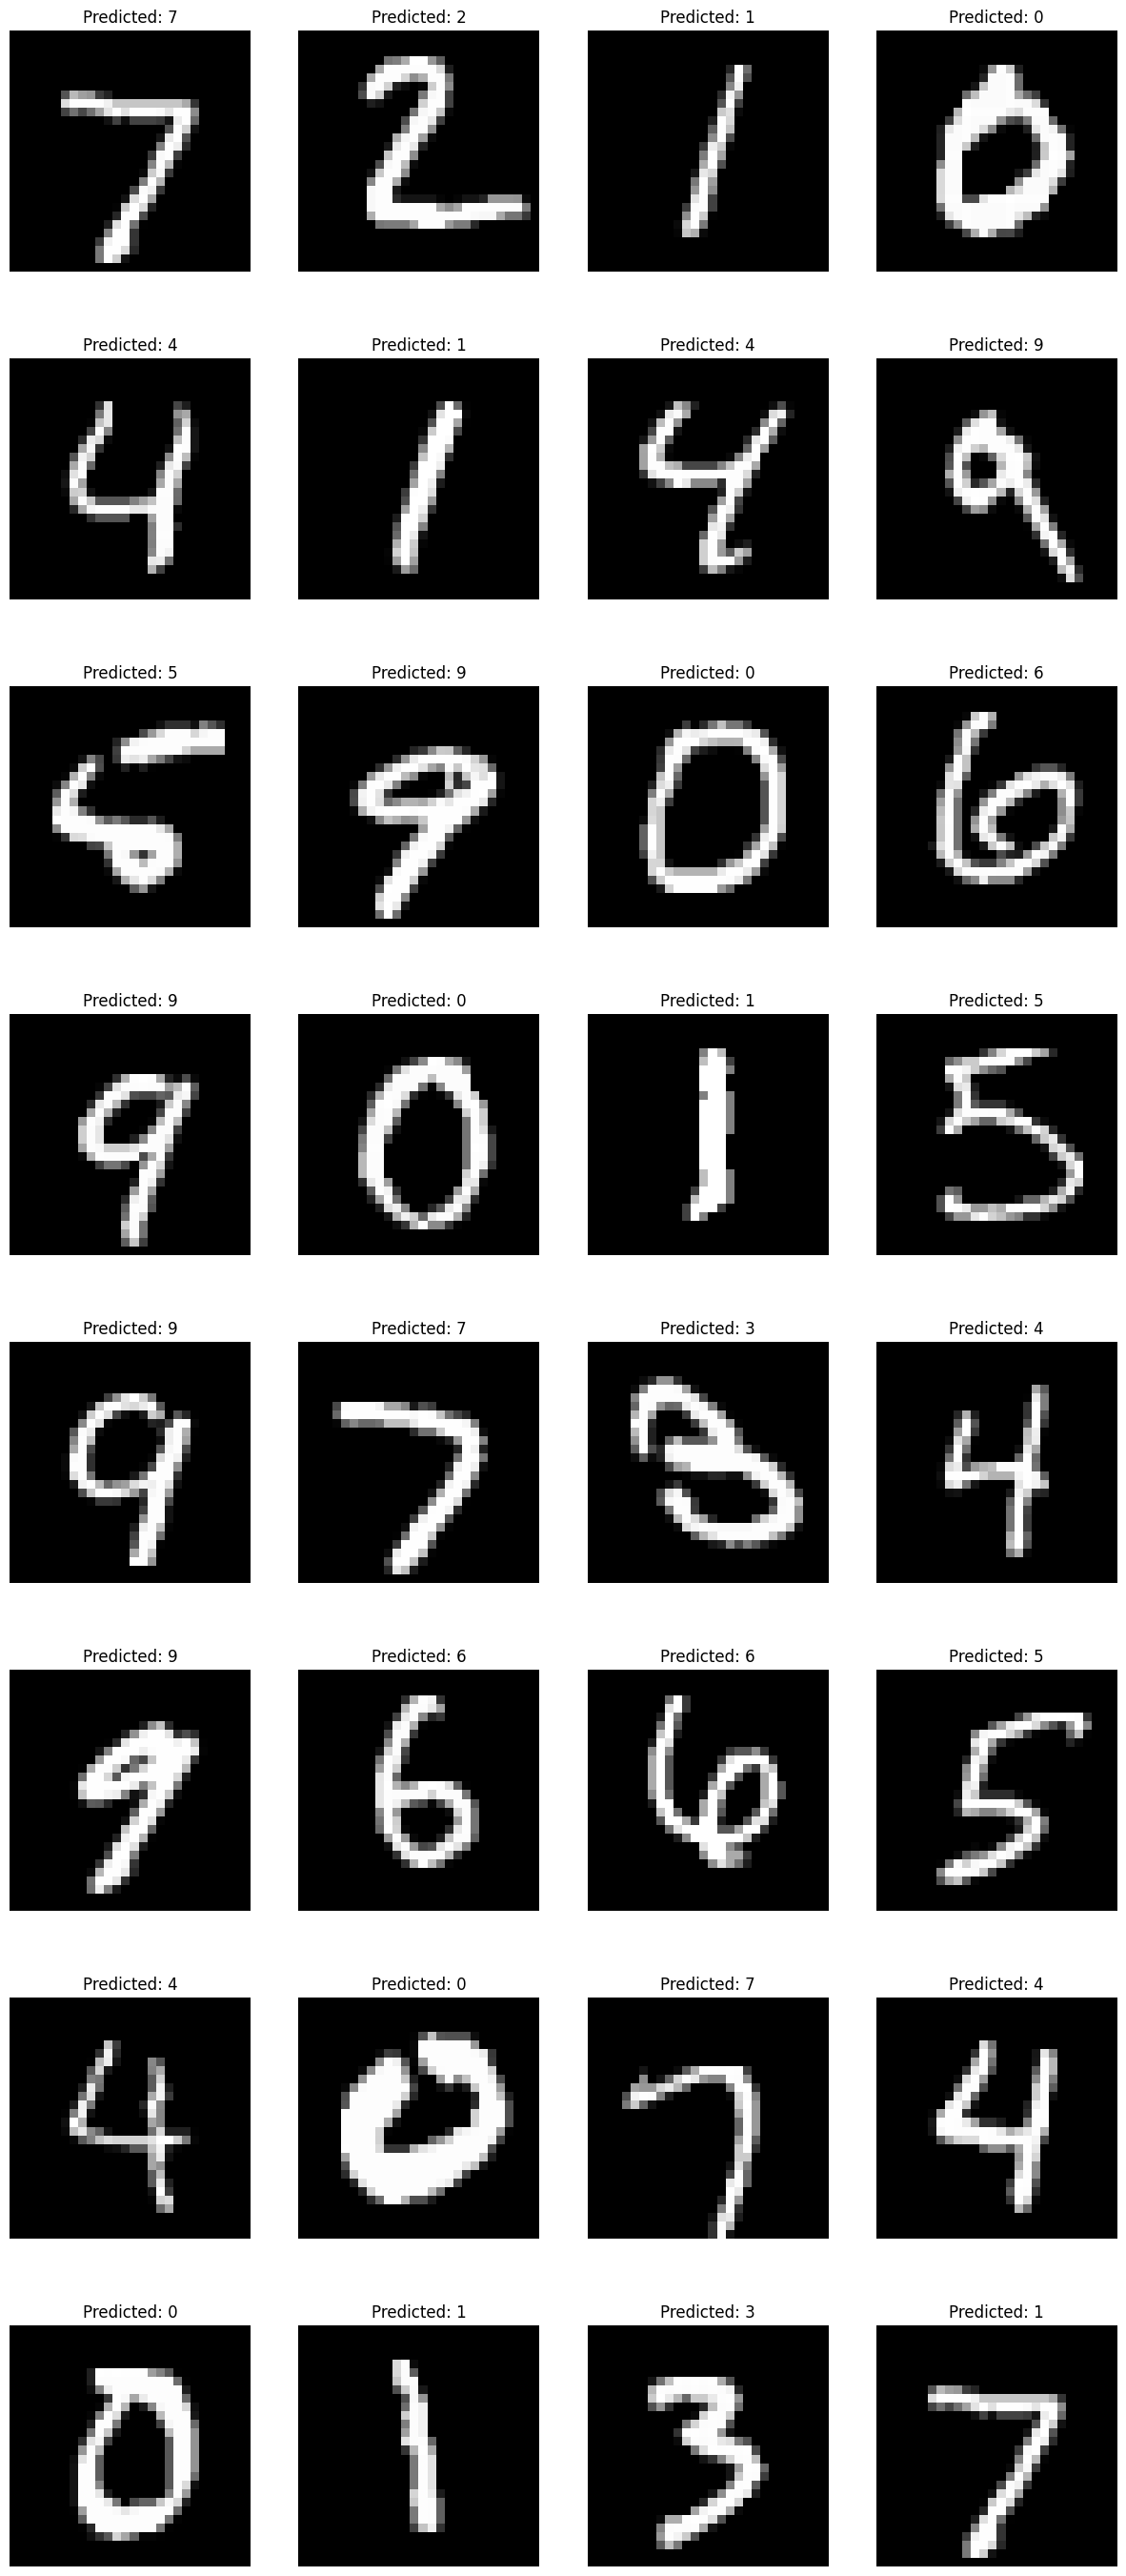

In [50]:
fig, ax = plt.subplots(8, 4, figsize=(15, 35))
batch_images, batch_true_labels = next(test_data_aug)
batch_predictions = model.predict(batch_images)
batch_true_indices = np.argmax(batch_true_labels, axis=1)
batch_pred_indices = np.argmax(batch_predictions, axis=1)

for i in range(32):
    ax[i // 4, i % 4].imshow(batch_images[i].squeeze(), cmap='gray')
    ax[i // 4, i % 4].axis('off')
    ax[i // 4, i % 4].set_title(f'Predicted: {batch_pred_indices[i]}')
#print('The batch's true indices are:')
print(batch_true_indices)
#print('The batch's predicted indices are:')
print(batch_pred_indices)
plt.imshow(batch_images[0].squeeze(), cmap='gray')